In [1]:
!pip install keras_tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [7]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, auc, roc_auc_score, roc_curve
import tensorflow as tf
import keras_tuner as kt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_X_train.csv', sep=",")
Y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_Y_train.csv', sep=",").iloc[:, 0]
X_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_X_val.csv', sep=",")
Y_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_Y_val.csv', sep=",").iloc[:, 0]
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_X_test.csv', sep=",")
Y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/hotel_bookings_Y_test.csv").iloc[:, 0]

In [ ]:
## Fetch the training, validation and test data.
X_train = pd.read_csv("/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed/hotel_bookings_X_train.csv")
X_val = pd.read_csv("/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed/hotel_bookings_X_val.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed/hotel_bookings_X_test.csv")
Y_train = pd.read_csv("/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed/hotel_bookings_Y_train.csv")
Y_val = pd.read_csv("/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed/hotel_bookings_Y_val.csv")
Y_test = pd.read_csv("/content/drive/MyDrive/Project_207/mids-207-summer-2025-keck/data/processed/hotel_bookings_Y_test.csv")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of Y_val: {Y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

Shape of X_train: (71632, 53)
Shape of Y_train: (71632, 1)
Shape of X_val: (23878, 53)
Shape of Y_val: (23878, 1)
Shape of X_test: (23878, 53)
Shape of Y_test: (23878, 1)


## Baseline Model: Logistic Regression

In [8]:
def build_model_tuner(hp, num_features, learning_rate):
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  np.random.seed(0)

  model = tf.keras.Sequential([tf.keras.layers.Input(shape=[num_features])])

  # Set up L2 Regularizer for penalty
  l2_reg_strength = hp.Float('l2_regularizer',
                                min_value=1e-5,
                                max_value=1e-2,
                                sampling='log',
                                default=1e-4)

  model.add(tf.keras.layers.Dense(
      units=1,
      use_bias=True,
      activation='sigmoid',
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
      kernel_regularizer=tf.keras.regularizers.l2(l2_reg_strength),
  ))

  # Set up learning rate for optimizer and use SGD
  hp_lr = hp.Choice('learning_rate', values=learning_rate)
  optimizer = tf.keras.optimizers.SGD(learning_rate=hp_lr)

  model.compile(
      optimizer=optimizer,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[
        tf.keras.metrics.Precision(thresholds=0),
        tf.keras.metrics.F1Score(threshold=0.5),
    ],
  )

  return model

In [11]:
# Set up Keras Tuner
num_epochs = 30
batch_size = 32
hp = kt.HyperParameters()
learning_rate = [0.0001, 0.001, 0.01]
tuner = kt.Hyperband(lambda hp: build_model_tuner(hp=hp,
                                                  num_features=X_train.shape[1],
                                                  learning_rate=learning_rate),
                     objective='val_loss',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner.search(x=X_train,
             y=Y_train,
             epochs=num_epochs,
             validation_data=(X_val, Y_val),
             callbacks=[stop_early])
best_hp_results = tuner.get_best_hyperparameters()[0]

Trial 30 Complete [00h 03m 06s]
val_loss: 1.1059777736663818

Best val_loss So Far: 0.41184312105178833
Total elapsed time: 00h 35m 16s


In [12]:
best_hp_results.values

{'l2_regularizer': 2.1850545842053132e-05,
 'learning_rate': 0.01,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0012'}

In [13]:
lr_model = tuner.hypermodel.build(best_hp_results)
lr_model_tf = lr_model.fit(
                        X_train,
                        Y_train,
                        epochs=30,
                        batch_size=batch_size,
                        validation_data=(X_val, Y_val),
                        verbose=0)

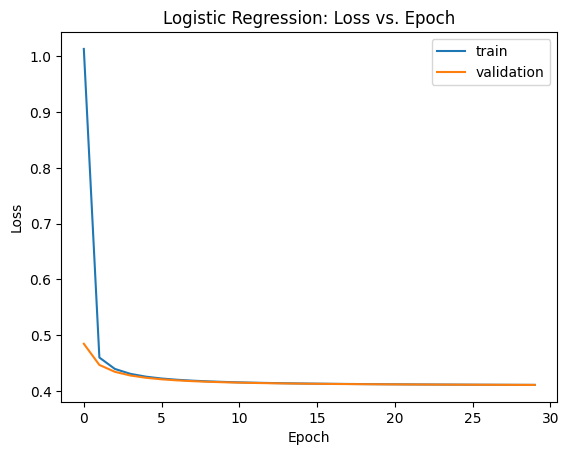

In [14]:
lr_history = lr_model_tf.history

# Plot loss and epoch of the best model
plt.plot(lr_history['loss'], label='train')
plt.plot(lr_history['val_loss'], label='validation')
plt.title('Logistic Regression: Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [16]:
# Get predicted probabilities
train_probs = lr_model.predict(X_train)
val_probs = lr_model.predict(X_val)
test_probs = lr_model.predict(X_test)

# Convert probabilities to binary class labels
train_preds = (train_probs >= 0.5).astype(int)
val_preds = (val_probs >= 0.5).astype(int)
test_preds = (test_probs >= 0.5).astype(int)

# Precision-Recall AUC
precision_train, recall_train, thresholds_train = precision_recall_curve(Y_train, train_probs)
pr_auc_train = auc(recall_train, precision_train)

precision_val, recall_val, thresholds_val = precision_recall_curve(Y_val, val_probs)
pr_auc_val = auc(recall_val, precision_val)

precision_test, recall_test, thresholds_test = precision_recall_curve(Y_test, test_probs)
pr_auc_test = auc(recall_test, precision_test)

# ROC AUC
fpr_train, tpr_train, thresholds_train = roc_curve(Y_train, train_preds)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_val, tpr_val, thresholds_val = roc_curve(Y_val, val_preds)
roc_auc_val = auc(fpr_val, tpr_val)

fpr_test, tpr_test, thresholds_test = roc_curve(Y_test, test_preds)
roc_auc_test = auc(fpr_test, tpr_test)

2239/2239 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


=> Training Set Results: 
Classification Report:

               precision    recall  f1-score   support

           0       0.81      0.92      0.86     45099
           1       0.82      0.64      0.72     26533

    accuracy                           0.82     71632
   macro avg       0.82      0.78      0.79     71632
weighted avg       0.82      0.82      0.81     71632

PR AUC Curve:




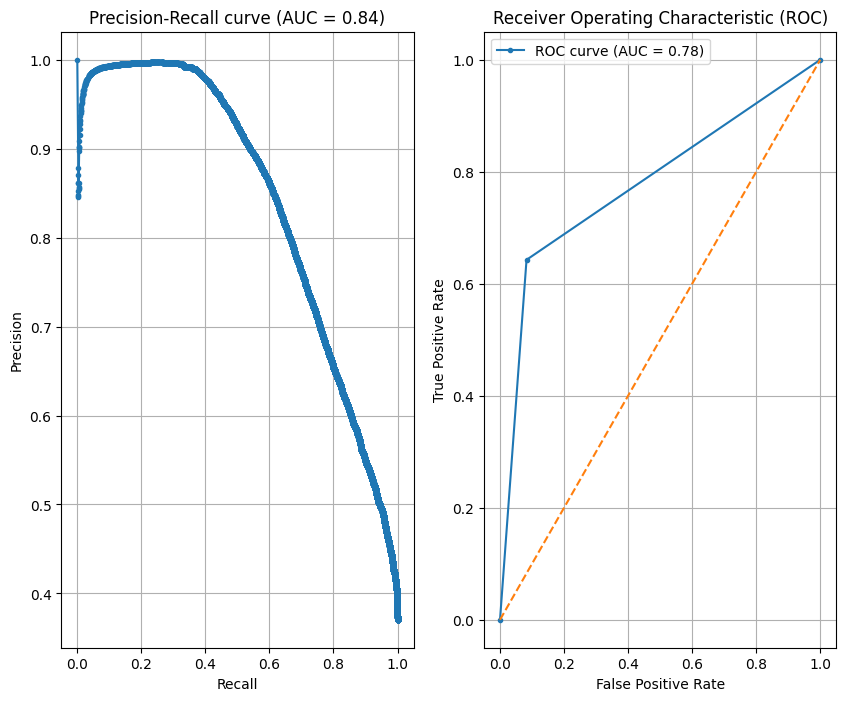

---------------------------------------------------------------------------
=> Validation Set Results: 
Classification Report:

               precision    recall  f1-score   support

           0       0.82      0.91      0.86     15033
           1       0.82      0.65      0.72      8845

    accuracy                           0.82     23878
   macro avg       0.82      0.78      0.79     23878
weighted avg       0.82      0.82      0.81     23878

PR AUC Curve:




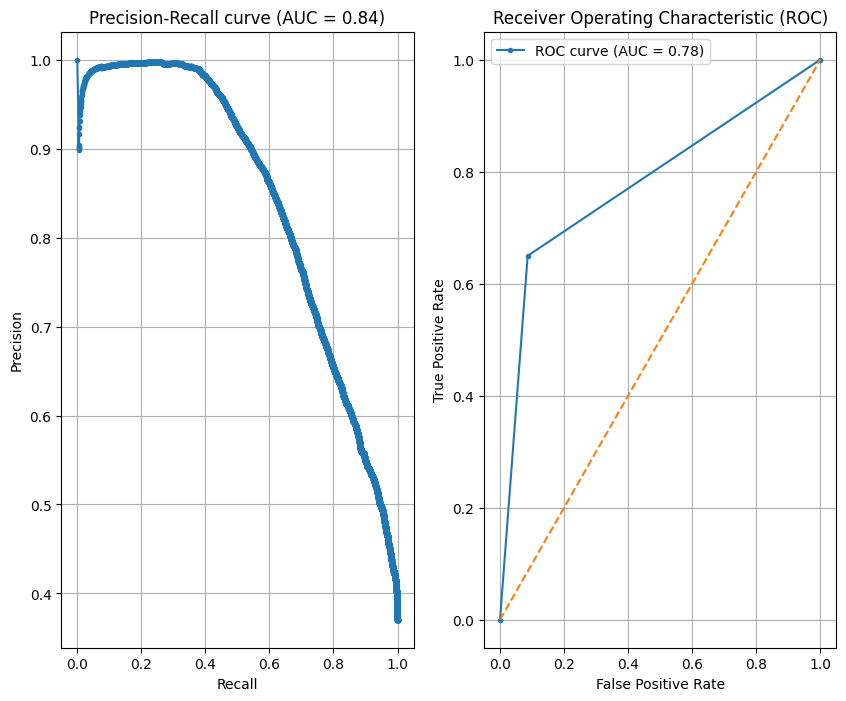

---------------------------------------------------------------------------
=> Test Set Results: 
Classification Report:

               precision    recall  f1-score   support

           0       0.81      0.92      0.86     15033
           1       0.82      0.63      0.71      8845

    accuracy                           0.81     23878
   macro avg       0.81      0.77      0.79     23878
weighted avg       0.81      0.81      0.80     23878

PR AUC Curve:




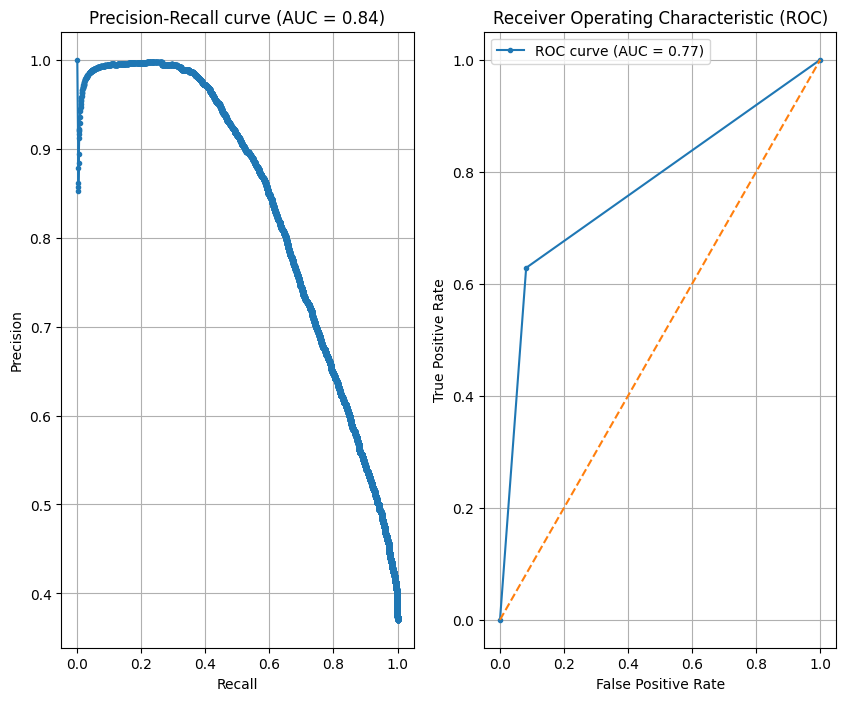

In [17]:
print("=> Training Set Results: ")
print(f"Classification Report:\n\n", classification_report(Y_train, train_preds))
print("PR AUC Curve:\n\n")

plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
plt.plot(recall_train, precision_train, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AUC = {pr_auc_train:.2f})')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(fpr_train, tpr_train, marker='.', label=f'ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid(True)

plt.show()

print("-"*75)

print("=> Validation Set Results: ")
print(f"Classification Report:\n\n", classification_report(Y_val, val_preds))
print("PR AUC Curve:\n\n")
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
plt.plot(recall_val, precision_val, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AUC = {pr_auc_val:.2f})')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(fpr_val, tpr_val, marker='.', label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid(True)
plt.show()

print("-"*75)

print("=> Test Set Results: ")
print(f"Classification Report:\n\n", classification_report(Y_test, test_preds))
print("PR AUC Curve:\n\n")
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
plt.plot(recall_test, precision_test, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AUC = {pr_auc_test:.2f})')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, marker='.', label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid(True)
plt.show()

plt.show()